In [127]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [128]:

# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

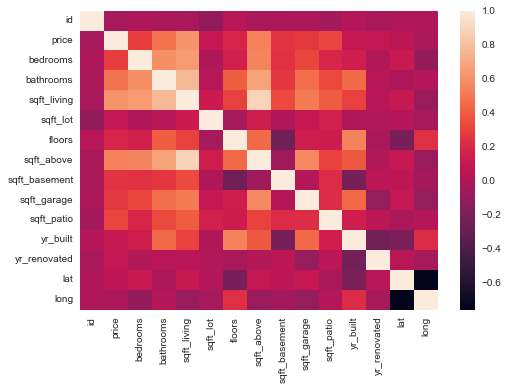

In [4]:
sns.heatmap(df.corr());

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

### Set Categorical Variables

In [6]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


In [7]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins=[0,1,2,3,4,5,6], labels=['1_bed','2_bed','3_bed','4_bed','5_bed','6_bed'])

### Drop NaNs

In [8]:
df.isna().sum()

id                 0
date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
greenbelt          0
nuisance           0
view               0
condition          0
grade              0
heat_source       32
sewer_system      14
sqft_above         0
sqft_basement      0
sqft_garage        0
sqft_patio         0
yr_built           0
yr_renovated       0
address            0
lat                0
long               0
zipcode            0
bedrooms_bin     181
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
bedrooms_bin     0
dtype: int64

# Train-Test Split

In [11]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [12]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [13]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [14]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Bedrooms

In [126]:
bedrooms_count = print(df['bedrooms'].value_counts())

3    11003
4     7569
2     3566
5     1985
6      331
1      260
Name: bedrooms, dtype: int64


In [16]:
#drop the 33 bedroom outlier
df = df[df['bedrooms'] != 0]
df = df[df['bedrooms'] != 7]
df = df[df['bedrooms'] != 8]
df = df[df['bedrooms'] != 9]
df = df[df['bedrooms'] != 10]
df = df[df['bedrooms'] != 11]
df = df[df['bedrooms'] != 33]

### Price

In [18]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -332500.0 
price_max: 2279500.0


In [19]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [20]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3345.5 
sqft_lot_max: 18218.5


In [21]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Condition

In [22]:
condition_count = print(df['condition'].value_counts())

Average      15472
Good          6543
Very Good     2658
Fair           155
Poor            38
Name: condition, dtype: int64


In [23]:
df = df[df['condition'] != 'Poor']

### Floors

In [24]:
floor_count = print(df['floors'].value_counts())

1.0    11821
2.0     9702
1.5     2032
3.0     1109
2.5      120
4.0       29
3.5       15
Name: floors, dtype: int64


In [25]:
df = df[df['floors'] != 4.0]
#df = df[df['floors'] != 2.5]
#df = df[df['floors'] != 3.5]

### Grade

In [26]:
grade_count = print(df['grade'].value_counts())

7 Average        10601
8 Good            8126
9 Better          2681
6 Low Average     2529
10 Very Good       494
5 Fair             283
11 Excellent        54
4 Low               26
12 Luxury            3
3 Poor               2
Name: grade, dtype: int64


In [27]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '4 Low']
df = df[df['grade'] != '11 Excellent']
df = df[df['grade'] != '12 Luxury']

# Categorical Variables

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24714 entries, 0 to 30154
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             24714 non-null  int64         
 1   date           24714 non-null  datetime64[ns]
 2   price          24714 non-null  float64       
 3   bedrooms       24714 non-null  int64         
 4   bathrooms      24714 non-null  float64       
 5   sqft_living    24714 non-null  int64         
 6   sqft_lot       24714 non-null  int64         
 7   floors         24714 non-null  float64       
 8   waterfront     24714 non-null  object        
 9   greenbelt      24714 non-null  object        
 10  nuisance       24714 non-null  object        
 11  view           24714 non-null  object        
 12  condition      24714 non-null  object        
 13  grade          24714 non-null  object        
 14  heat_source    24714 non-null  object        
 15  sewer_system   2471

In [131]:
df.drop(['id', 'date', 'heat_source', 'nuisance', 'greenbelt', 'sewer_system', 'sqft_garage', 'sqft_basement'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_patio,yr_built,yr_renovated,address,lat,long
0,675000.0,4,1.0,1180,7140,1.0,NO,NONE,Good,7 Average,1180,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,920000.0,5,2.5,2770,6703,1.0,NO,AVERAGE,Average,7 Average,1570,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,311000.0,6,2.0,2880,6156,1.0,NO,AVERAGE,Average,7 Average,1580,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,775000.0,3,3.0,2160,1400,2.0,NO,AVERAGE,Average,9 Better,1090,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,592500.0,2,2.0,1120,758,2.0,NO,NONE,Average,7 Average,1120,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30155 non-null  float64
 1   bedrooms      30155 non-null  int64  
 2   bathrooms     30155 non-null  float64
 3   sqft_living   30155 non-null  int64  
 4   sqft_lot      30155 non-null  int64  
 5   floors        30155 non-null  float64
 6   waterfront    30155 non-null  object 
 7   view          30155 non-null  object 
 8   condition     30155 non-null  object 
 9   grade         30155 non-null  object 
 10  sqft_above    30155 non-null  int64  
 11  sqft_patio    30155 non-null  int64  
 12  yr_built      30155 non-null  int64  
 13  yr_renovated  30155 non-null  int64  
 14  address       30155 non-null  object 
 15  lat           30155 non-null  float64
 16  long          30155 non-null  float64
dtypes: float64(5), int64(7), object(5)
memory usage: 3.9+ MB


### Bedroom Bins

In [30]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

In [31]:
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,address,lat,long,zipcode,bedrooms_bin,bedrooms_bin_x0_2_bed,bedrooms_bin_x0_3_bed,bedrooms_bin_x0_4_bed,bedrooms_bin_x0_5_bed,bedrooms_bin_x0_6_bed
19369,844000260,2021-09-18,4,2.5,2580,19212,1.0,NO,NO,YES,...,"32330 3rd Avenue, Black Diamond, Washington 98...",47.311340,-122.003650,98010,4_bed,0.0,0.0,1.0,0.0,0.0
3399,8724900070,2021-10-28,3,2.5,1620,1137,2.0,NO,NO,NO,...,"14644 35th Avenue Northeast, Lake Forest Park,...",47.734750,-122.291015,98155,3_bed,0.0,1.0,0.0,0.0,0.0
28213,8159100046,2021-07-02,3,2.5,1320,946,3.0,NO,NO,YES,...,"700 South Willow Street, Effingham, Illinois 6...",39.115995,-88.537060,62401,3_bed,0.0,1.0,0.0,0.0,0.0
461,3905081460,2021-10-21,4,3.0,2130,5949,2.0,NO,NO,NO,...,"25732 Southeast 41st Street, Sammamish, Washin...",47.570210,-121.996790,98029,4_bed,0.0,0.0,1.0,0.0,0.0
8455,6791100210,2021-09-21,5,2.5,1900,18576,1.0,NO,NO,NO,...,"21711 Southeast 35th Street, Sammamish, Washin...",47.578040,-122.049210,98075,5_bed,0.0,0.0,0.0,1.0,0.0


### Condition

In [32]:
condition_count = df['condition'].value_counts()
condition_count

Average      15375
Good          6531
Very Good     2656
Fair           152
Name: condition, dtype: int64

In [33]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [34]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [35]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [36]:
floor_count = print(df['floors'].value_counts())

1.0    11792
2.0     9651
1.5     2028
3.0     1108
2.5      120
3.5       15
Name: floors, dtype: int64


In [37]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [38]:
X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [39]:
X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [40]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### View

In [41]:
X_train['view'].isna().sum()

0

In [42]:
view_count = df['view'].value_counts()
view_count

NONE         22549
AVERAGE       1335
GOOD           491
EXCELLENT      179
FAIR           160
Name: view, dtype: int64

In [43]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [44]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [45]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [46]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [47]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [48]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [49]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         30155 non-null  float64
 1   bedrooms      30155 non-null  int64  
 2   bathrooms     30155 non-null  float64
 3   sqft_living   30155 non-null  int64  
 4   sqft_lot      30155 non-null  int64  
 5   floors        30155 non-null  float64
 6   waterfront    30155 non-null  object 
 7   view          30155 non-null  object 
 8   condition     30155 non-null  object 
 9   grade         30155 non-null  object 
 10  sqft_above    30155 non-null  int64  
 11  sqft_patio    30155 non-null  int64  
 12  yr_built      30155 non-null  int64  
 13  yr_renovated  30155 non-null  int64  
 14  address       30155 non-null  object 
 15  lat           30155 non-null  float64
 16  long          30155 non-null  float64
dtypes: float64(5), int64(7), object(5)
memory usage: 3.9+ MB


### Zipcode

In [50]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [51]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -7.222392337880024e-05


In [52]:
df.corr()['price'].abs().sort_values(ascending=False)

price           1.000000
sqft_living     0.551814
sqft_above      0.447575
bathrooms       0.420212
bedrooms        0.317409
sqft_patio      0.226357
floors          0.180054
lat             0.082038
yr_renovated    0.065335
sqft_lot        0.054041
yr_built        0.047135
long            0.027527
zipcode         0.024641
Name: price, dtype: float64

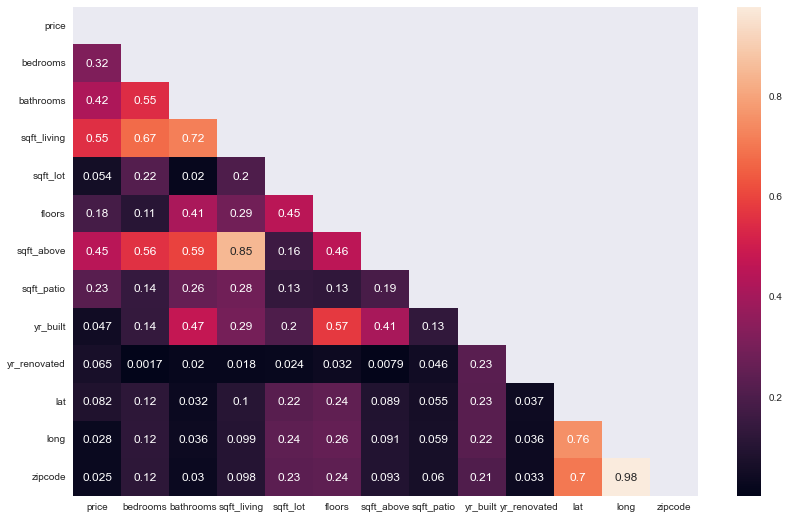

In [53]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight")

### Model 1

In [54]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [55]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.36919866442637805
    test score: 0.38973691198412186


In [56]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                 1.082e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        22:12:05   Log-Likelihood:            -3.5077e+05
No. Observations:               24714   AIC:                         7.015e+05
Df Residuals:                   24712   BIC:                         7.016e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.189e+05   6222.129     51.256      0.000    3.07e+05    3.31e+05
sqft_living   313.2122      3.011    104.016      0.000     307.310     319.114
==============================================================================
Omnibus:                     1394.229   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1747.331
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.662   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [57]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [58]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5769839655260836
    test score: 0.6241176858195137


In [59]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.577
Mean Absolute Error: 277785.394
Mean Squared Error: 337241595280.593
Root Mean Squared Error: 580725.060

Testing Metrics:
R2: 0.624
Mean Absolute Error: 282330.155
Mean Squared Error: 289629955460.796
Root Mean Squared Error: 538172.793


### Model 2b

In [60]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [61]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3705594753653326
    test score: 0.3906230695398668


In [62]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.371
Mean Absolute Error: 392067.208
Mean Squared Error: 501809646355.469
Root Mean Squared Error: 708385.239

Testing Metrics:
R2: 0.391
Mean Absolute Error: 397930.100
Mean Squared Error: 469545404424.796
Root Mean Squared Error: 685233.832


### Model 3

In [63]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [64]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3843159070832992
    test score: 0.4089323758596367


In [65]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.384
Mean Absolute Error: 386303.868
Mean Squared Error: 490842589317.772
Root Mean Squared Error: 700601.591

Testing Metrics:
R2: 0.409
Mean Absolute Error: 391562.592
Mean Squared Error: 455437468579.305
Root Mean Squared Error: 674861.074


### Model 3b

In [66]:
cols = ['sqft_living', 'sqft_living15'] + encoded_bedrooms_bins + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [67]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5854215069281011
    test score: 0.6328040156392192


In [68]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.585
Mean Absolute Error: 278173.242
Mean Squared Error: 330514923734.439
Root Mean Squared Error: 574904.274

Testing Metrics:
R2: 0.633
Mean Absolute Error: 282522.642
Mean Squared Error: 282936846410.735
Root Mean Squared Error: 531918.082


### Model 4

In [69]:
cols = ['bedrooms', 'sqft_living'] + encoded_condition + encoded_zipcode 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [70]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5845797754542226
    test score: 0.6346814416862676


In [71]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.585
Mean Absolute Error: 275575.114
Mean Squared Error: 331185978356.285
Root Mean Squared Error: 575487.601

Testing Metrics:
R2: 0.635
Mean Absolute Error: 278325.866
Mean Squared Error: 281490226546.289
Root Mean Squared Error: 530556.525


### Model 4b

In [72]:
cols = ['sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [73]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5863760452175575
    test score: 0.6344814731885833


In [74]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.586
Mean Absolute Error: 276269.555
Mean Squared Error: 329753935995.776
Root Mean Squared Error: 574242.053

Testing Metrics:
R2: 0.634
Mean Absolute Error: 279975.802
Mean Squared Error: 281644308994.153
Root Mean Squared Error: 530701.714


### Model 5

In [75]:
cols = ['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'view'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [76]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6065328987135696
    test score: 0.6532451761542746


In [77]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.607
Mean Absolute Error: 272018.557
Mean Squared Error: 313684262804.105
Root Mean Squared Error: 560075.230

Testing Metrics:
R2: 0.653
Mean Absolute Error: 276181.488
Mean Squared Error: 267186245261.941
Root Mean Squared Error: 516900.614


### Model 5b

In [78]:
cols = ['bathrooms', 'sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [79]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6217612979513419
    test score: 0.6645872449737902


In [80]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267796.063
Mean Squared Error: 301543707283.786
Root Mean Squared Error: 549129.955

Testing Metrics:
R2: 0.665
Mean Absolute Error: 271638.608
Mean Squared Error: 258446800060.345
Root Mean Squared Error: 508376.632


### Model 6

In [81]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [82]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6205300196039054
    test score: 0.6649021751112454


In [83]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.621
Mean Absolute Error: 266910.830
Mean Squared Error: 302525320840.445
Root Mean Squared Error: 550023.018

Testing Metrics:
R2: 0.665
Mean Absolute Error: 269821.786
Mean Squared Error: 258204135805.488
Root Mean Squared Error: 508137.910


### Model 6b

In [84]:
cols = ['bathrooms', 'sqft_living', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [85]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6217974291849722
    test score: 0.6646691777142735


In [86]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267634.150
Mean Squared Error: 301514902335.803
Root Mean Squared Error: 549103.726

Testing Metrics:
R2: 0.665
Mean Absolute Error: 271494.706
Mean Squared Error: 258383668130.266
Root Mean Squared Error: 508314.537


### Model 7

In [87]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [88]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6205300196039054
    test score: 0.6649021751112454


In [89]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.621
Mean Absolute Error: 266910.830
Mean Squared Error: 302525320840.445
Root Mean Squared Error: 550023.018

Testing Metrics:
R2: 0.665
Mean Absolute Error: 269821.786
Mean Squared Error: 258204135805.488
Root Mean Squared Error: 508137.910


### Model 7b

In [90]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [91]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6217974291849722
    test score: 0.6646691777142735


In [92]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267634.150
Mean Squared Error: 301514902335.803
Root Mean Squared Error: 549103.726

Testing Metrics:
R2: 0.665
Mean Absolute Error: 271494.706
Mean Squared Error: 258383668130.266
Root Mean Squared Error: 508314.537


### Model 8

In [93]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [94]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5871657670886483
    test score: 0.6352975951571485


In [95]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.587
Mean Absolute Error: 275973.470
Mean Squared Error: 329124345053.754
Root Mean Squared Error: 573693.599

Testing Metrics:
R2: 0.635
Mean Absolute Error: 279573.691
Mean Squared Error: 281015459589.729
Root Mean Squared Error: 530108.913


### Model 9

In [96]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [97]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6610531650830107
    test score: 0.6871279031843542


In [98]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.661
Mean Absolute Error: 243569.532
Mean Squared Error: 270219003553.544
Root Mean Squared Error: 519825.936

Testing Metrics:
R2: 0.687
Mean Absolute Error: 247289.802
Mean Squared Error: 241078465378.741
Root Mean Squared Error: 490997.419


### Model 10

In [99]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [100]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6215171334686965
    test score: 0.6643468220222697


In [101]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267634.292
Mean Squared Error: 301738362835.650
Root Mean Squared Error: 549307.166

Testing Metrics:
R2: 0.664
Mean Absolute Error: 271680.680
Mean Squared Error: 258632054024.455
Root Mean Squared Error: 508558.801


### Model 11

In [102]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [103]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6217135757939896
    test score: 0.6642281149867956


In [104]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267312.529
Mean Squared Error: 301581752878.194
Root Mean Squared Error: 549164.595

Testing Metrics:
R2: 0.664
Mean Absolute Error: 271684.466
Mean Squared Error: 258723521784.709
Root Mean Squared Error: 508648.721


### Model 11b

In [105]:
cols = ['floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [106]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6215607239731327
    test score: 0.6641093633619073


In [107]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267584.565
Mean Squared Error: 301703611123.996
Root Mean Squared Error: 549275.533

Testing Metrics:
R2: 0.664
Mean Absolute Error: 271858.168
Mean Squared Error: 258815023902.605
Root Mean Squared Error: 508738.660


### Model 12

In [108]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [109]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.661280386556891
    test score: 0.6869950595117216


In [110]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.661
Mean Absolute Error: 243170.161
Mean Squared Error: 270037855497.469
Root Mean Squared Error: 519651.667

Testing Metrics:
R2: 0.687
Mean Absolute Error: 247356.460
Mean Squared Error: 241180825893.020
Root Mean Squared Error: 491101.645


### Model 12b

In [111]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [112]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6611125311687585
    test score: 0.6869974460375212


In [113]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.661
Mean Absolute Error: 243493.575
Mean Squared Error: 270171675055.729
Root Mean Squared Error: 519780.410

Testing Metrics:
R2: 0.687
Mean Absolute Error: 247303.703
Mean Squared Error: 241178986994.686
Root Mean Squared Error: 491099.773


### Model 13

In [114]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [115]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6614870682296508
    test score: 0.6872270654630688


In [116]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.661
Mean Absolute Error: 243439.495
Mean Squared Error: 269873082412.394
Root Mean Squared Error: 519493.101

Testing Metrics:
R2: 0.687
Mean Absolute Error: 246973.117
Mean Squared Error: 241002057510.416
Root Mean Squared Error: 490919.604


### Model 14

In [117]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [118]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6621989256363913
    test score: 0.6872937695356521


In [119]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.662
Mean Absolute Error: 243101.850
Mean Squared Error: 269305567453.392
Root Mean Squared Error: 518946.594

Testing Metrics:
R2: 0.687
Mean Absolute Error: 246458.306
Mean Squared Error: 240950659780.748
Root Mean Squared Error: 490867.253


### Model 15

In [120]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [121]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6224336801162205
    test score: 0.6643575275227729


In [122]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.622
Mean Absolute Error: 267114.250
Mean Squared Error: 301007663220.577
Root Mean Squared Error: 548641.653

Testing Metrics:
R2: 0.664
Mean Absolute Error: 271137.052
Mean Squared Error: 258623805076.534
Root Mean Squared Error: 508550.691


### Model 16

In [137]:
cols = ['sqft_living'] + encoded_zipcode + encoded_grade + encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [138]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6583774841259542
    test score: 0.684708495326343


In [139]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.658
Mean Absolute Error: 245724.448
Mean Squared Error: 272352139985.457
Root Mean Squared Error: 521873.682

Testing Metrics:
R2: 0.685
Mean Absolute Error: 249545.579
Mean Squared Error: 242942700443.072
Root Mean Squared Error: 492892.179
